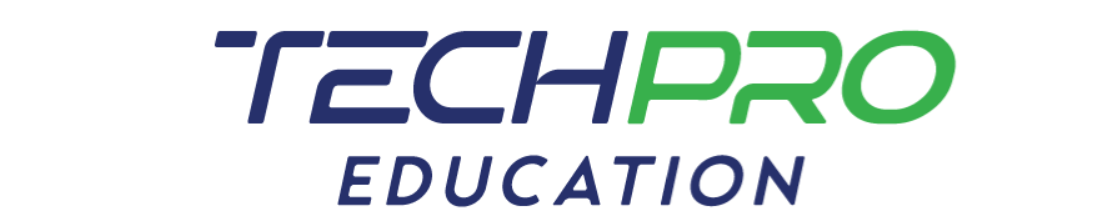

# Hierarchical Clustering - USArrest data sets

NOT: Dendrogram ile clustering yaklaşımı elde edeceğimiz 2.data seti örneği

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

veri seti, ABD'nin çeşitli eyaletlerine ait suç istatistiklerini içeriyor

In [2]:
df = pd.read_csv("USArrest.csv", index_col=0)   # datasetinin ilk index i eyalet isimleri oluşacak şekilde düzenledik

In [3]:
df.head()

,Murder,Assault,UrbanPop,Rape
Alabama,0.8,45,58,7.3
Alaska,2.1,46,48,7.8
Arizona,2.1,48,80,8.3
Arkansas,2.2,53,50,9.3
California,2.2,56,91,9.5


**SENARYO**:   Eyaletlerdeki suç oranına göre güvenlik personeli istihdamı olacağını varsayalım.

buna göre eyaletleri uygun şekilde kümelememiz isteniyor. Mesela suç oranı **yüksek-orta-düşük** gibi ayırıp politikacıların ona göre politika üretmesini sağlayacağımızı varsayalım

## Exploratory Data Analysis and Visualization

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


min-max değerlerine bakınca farklı eyaletlerde farklı suç oranları olduğunu gördüm. demekki bazı eyaletlerde suç oranları çok düşük bazılarında çok yüksek

yine feature'ların aralarındaki min-max değerlerinden scale yapmam gerekitğini gördüm

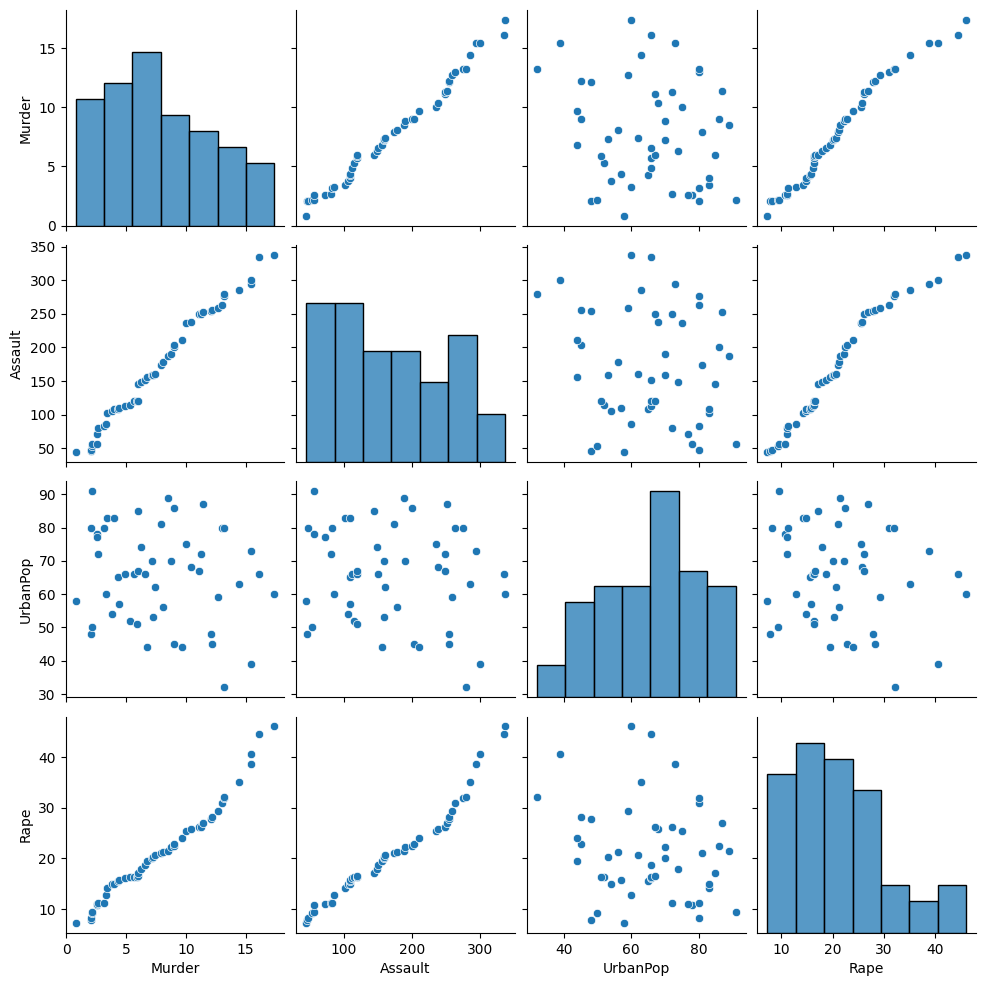

In [7]:
sns.pairplot(df);

### Suçlara göre eyaletlerin genel durumu

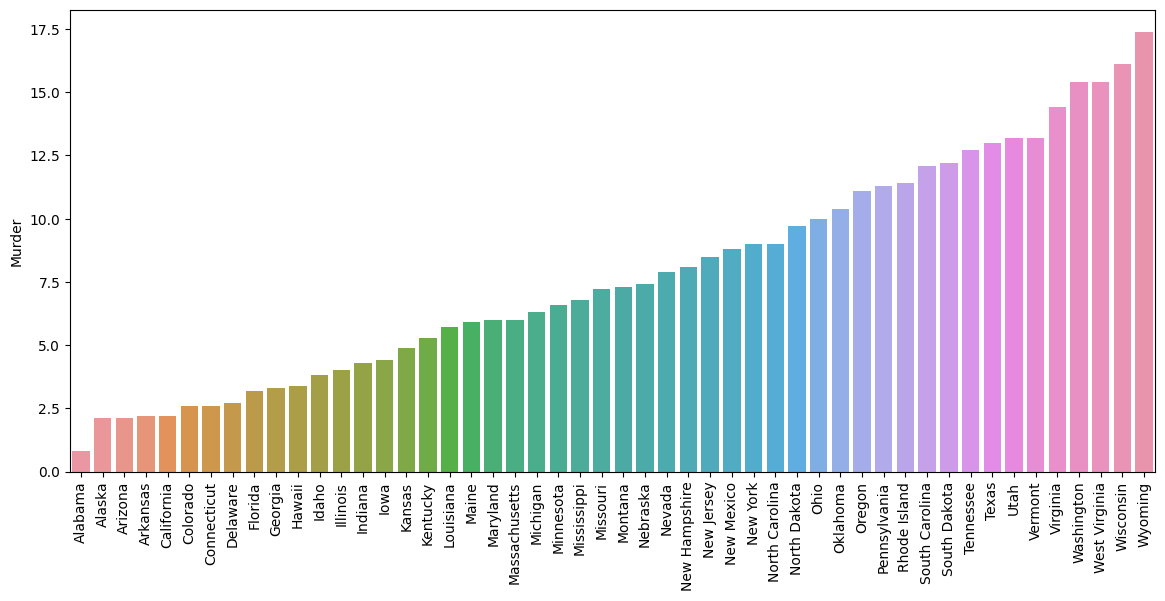

In [8]:
# Murder (cinayet) sayılarına göre

plt.figure(figsize = (14,6))
sns.barplot(y = df.Murder.sort_values(), x = df.Murder.sort_values().index)
plt.xticks(rotation = 90);

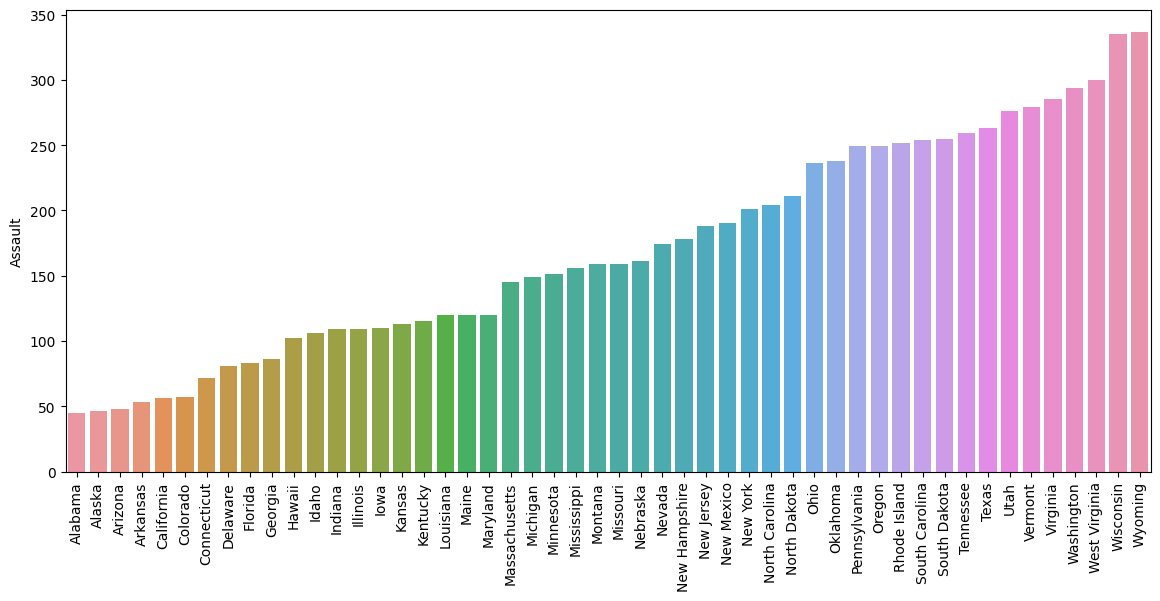

In [9]:
# Assault (saldırı suçları) değerlerine göre eyaletler

plt.figure(figsize = (14,6))
sns.barplot(y = df.Assault.sort_values(), x = df.Assault.sort_values().index)
plt.xticks(rotation = 90);

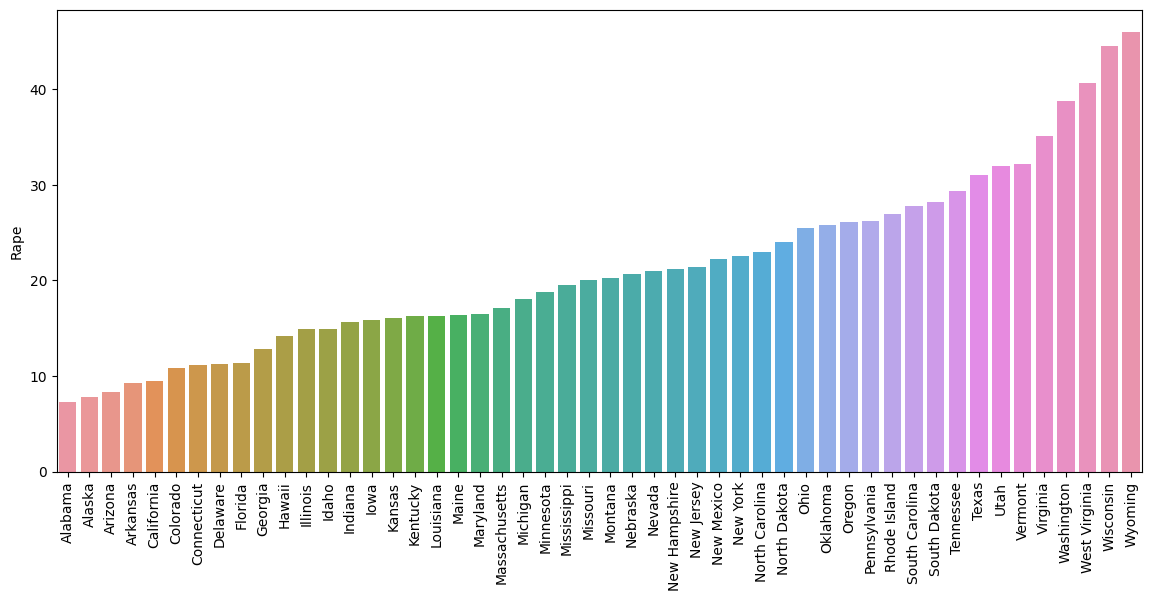

In [10]:
# Rape değerlerine göre eylatler
plt.figure(figsize = (14,6))
sns.barplot(y = df.Rape.sort_values(), x = df.Rape.sort_values().index)
plt.xticks(rotation = 90);

## Hopkins Test

In [11]:
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd
def hopkins(data_frame, sampling_size):
    """Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
    no clusterability and a score tending to 0 express a high cluster tendency.
    Parameters
    ----------
    data_frame : numpy array
        The input dataset
    sampling_size : int
        The sampling size which is used to evaluate the number of DataFrame.
    Returns
    ---------------------
    score : float
        The hopkins score of the dataset (between 0 and 1)
    Examples
    --------
    >>> from sklearn import datasets
    >>> from pyclustertend import hopkins
    >>> X = datasets.load_iris().data
    >>> hopkins(X,150)
    0.16
    """
    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)
    # Sample n observations from D : P
    if sampling_size > data_frame.shape[0]:
        raise Exception(
            'The number of sample of sample is bigger than the shape of D')
    data_frame_sample = data_frame.sample(n=sampling_size)
    # Get the distance to their neirest neighbors in D : X
    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]
    # Randomly simulate n points with the same variation as in D : Q.
    max_data_frame = data_frame.max()
    min_data_frame = data_frame.min()
    uniformly_selected_values_0 = np.random.uniform(min_data_frame[0], max_data_frame[0], sampling_size)
    uniformly_selected_values_1 = np.random.uniform(min_data_frame[1], max_data_frame[1], sampling_size)
    uniformly_selected_observations = np.column_stack((uniformly_selected_values_0, uniformly_selected_values_1))
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(min_data_frame[i], max_data_frame[i], sampling_size)
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)
    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)
    # Get the distance to their neirest neighbors in D : Y
    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations_df, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist
    # return the hopkins score
    x = sum(data_frame_sample_distances_to_nearest_neighbours)
    y = sum(uniformly_df_distances_to_nearest_neighbours)
    if x + y == 0:
        raise Exception('The denominator of the hopkins statistics is null')
    return x / (x + y)[0]


In [12]:
hopkins(df, df.shape[0])  # butun satırları dikkate alarak hesaplar. buyuk data setlerinde alt kumelerle hesaplanabilir

0.342628331563338

hopkins için 0.5 n altı kabul edileibir ama 0.3 ün altı iyi kümelemeneiblir 

data henüz scale edilmiş durumda değil..  

## Scale

Her 2 scaler da denenebilir.. En iy skorla decam edilir..  Bizim işlemlerde MinMaxScaler daha iyi sonuç veridği için bu metotla devam ediyorum

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [14]:
df1 = df.copy()
df2 = df.copy()

In [15]:
hopkins(MinMaxScaler().fit_transform(df1), df1.shape[0])  # hem scaler hem fit_transform hem de hopkins yaptık

0.24068166235517996

In [16]:
hopkins(StandardScaler().fit_transform(df2), df2.shape[0])

0.21406679165831136

In [17]:
scaler = MinMaxScaler()

In [18]:
df_scaled = scaler.fit_transform(df)

In [19]:
X = pd.DataFrame(df_scaled, columns=df.columns)

## Dendrogram

Kümelerin ağaç benzeri hiyerarşik temsiline dendrogram adı verilir.
İlgili analizler tarafından üretilen kümelerin düzenini gösterir.

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage

**“linkage” parameter: (default= “ward”)**

  {‘ward’, ‘complete’, ‘average’, ‘single’}

In [21]:
# linkage ile metrikleri tanımla

hc_ward = linkage(y = X, method = "ward")
hc_complete = linkage(X, "complete")
hc_average = linkage(X, "average")
hc_single = linkage(X, "single")

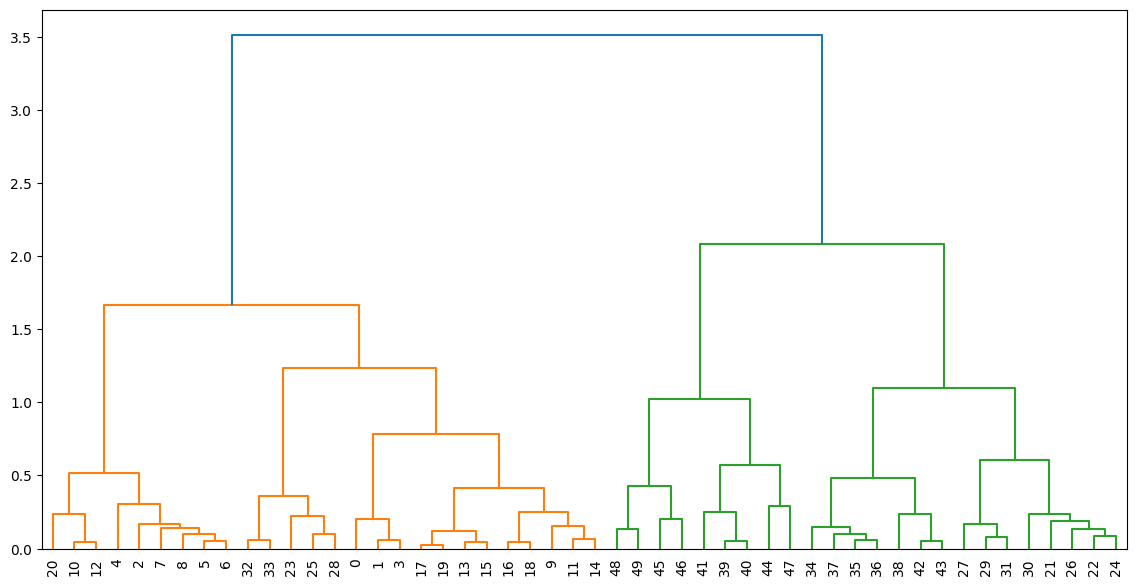

In [22]:
#ward uzerinden dendrgram çizelim

plt.figure(figsize = (14,7))
dendrogram(hc_ward, leaf_font_size = 10);

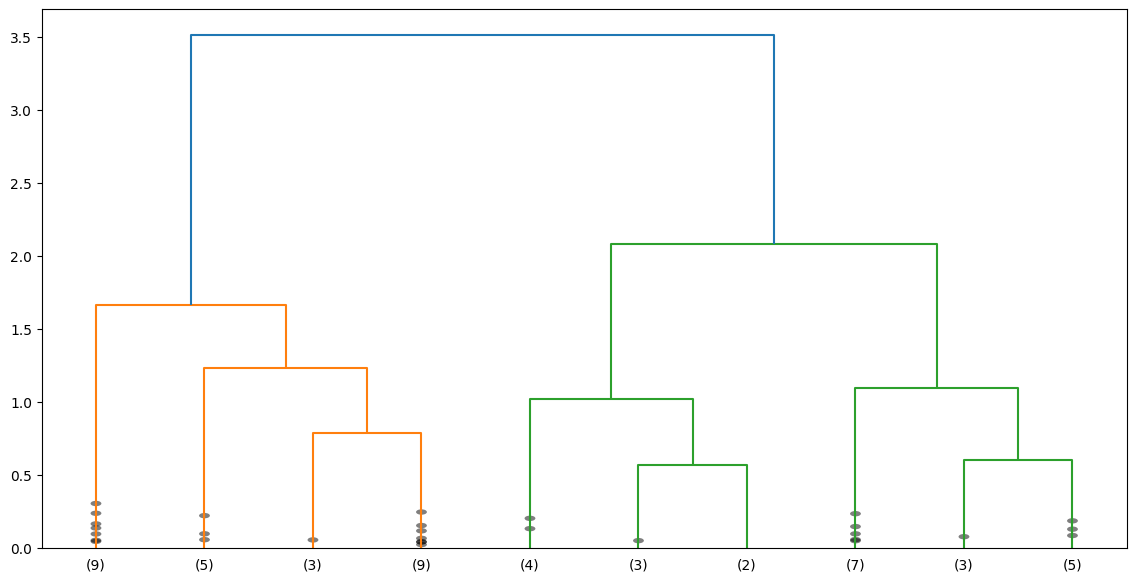

In [23]:
# daha sade dendrogram çizimi

plt.figure(figsize = (14,7))
dendrogram(hc_ward,
           truncate_mode = "lastp",
           p = 10,
           show_contracted = True,  # çizgilerin altındaki kucuk çizgileri ekler- 
           leaf_font_size = 10);

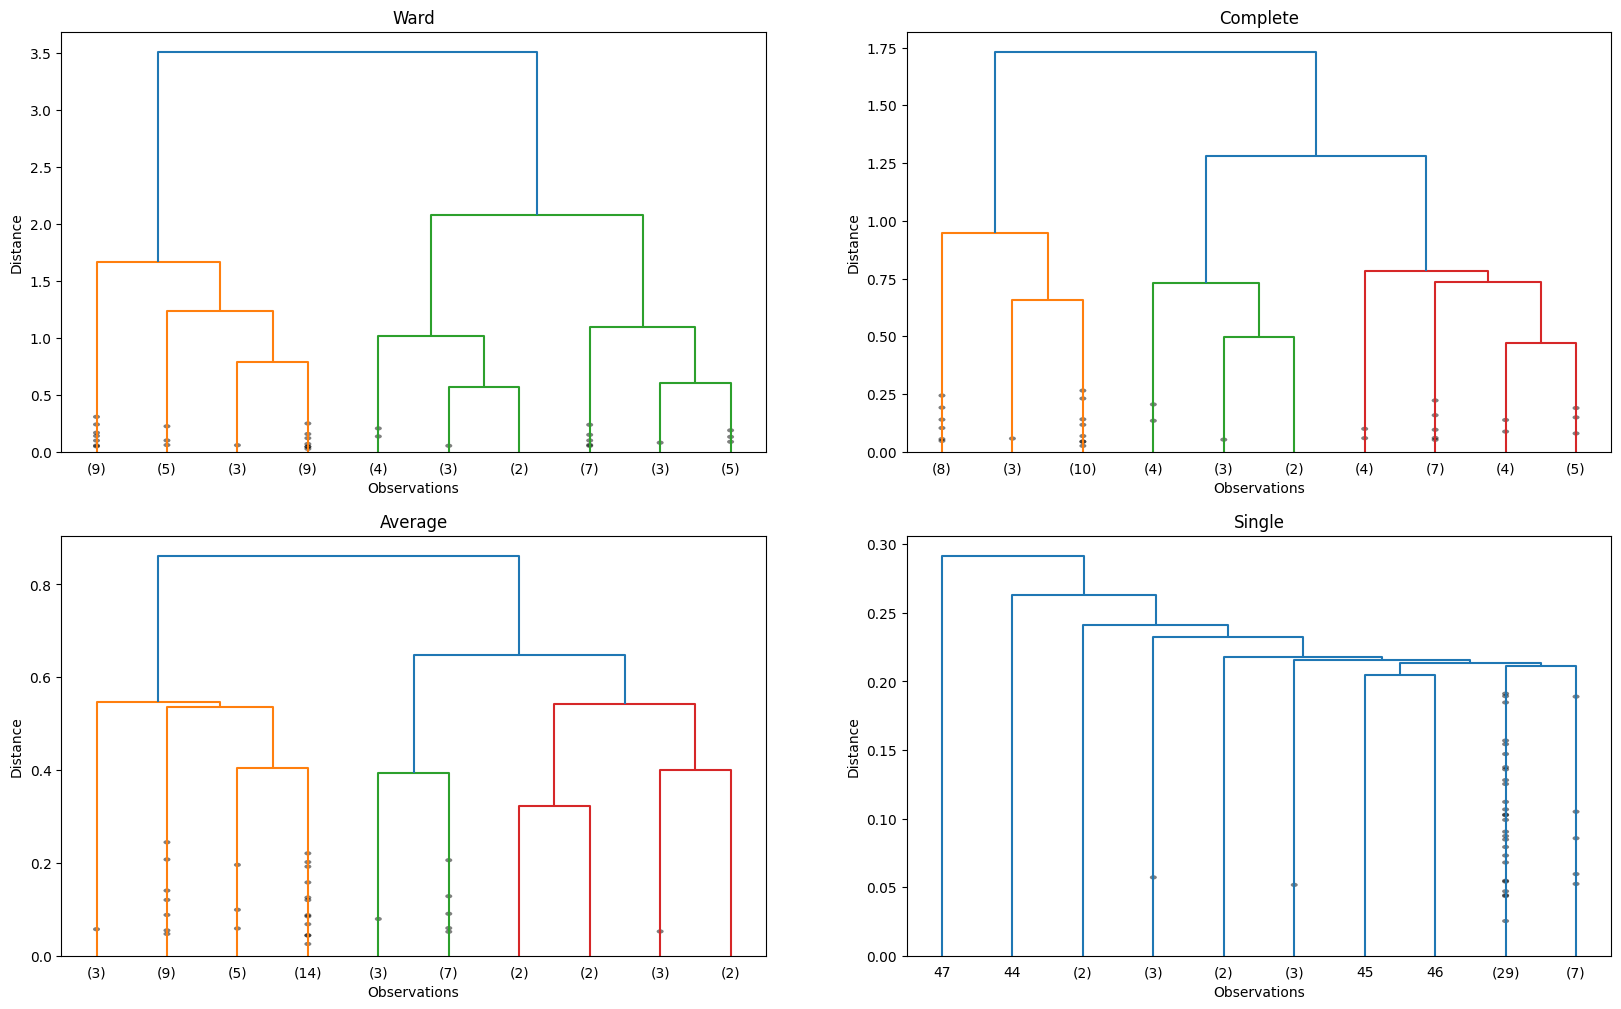

In [24]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10);

Senaryoya göre, bizden 3 cluster olması isteniyordu (biz de 3 oalark cluster alacağız ve yolumuza devam edeceğiz. eğer 2 cluster çıksayd biz bu durumu yetkilelere bildirirp 3 cluster önerilerini tekrar değerlendirimelerini isterdik)

## Hierarchical Clustering (Agglomerative)

İdeal kümeleme minimum küme içi mesafe ve maksimum kümeler arası mesafe ile karakterize edilir

In [25]:
from sklearn.cluster import AgglomerativeClustering

### S(Silhouette) Score

In [26]:
from sklearn.cluster import AgglomerativeClustering

In [27]:
from sklearn.metrics import silhouette_score

In [28]:
K = range(2,11)

for k in K:
    model = AgglomerativeClustering(n_clusters = k)
    model.fit_predict(X)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(df, model.labels_)}')

Silhouette Score for 2 clusters: 0.45421907210414214
Silhouette Score for 3 clusters: 0.3180902156279954
Silhouette Score for 4 clusters: 0.13602999771899232
Silhouette Score for 5 clusters: 0.16195986543258523
Silhouette Score for 6 clusters: 0.22945281939930115
Silhouette Score for 7 clusters: 0.24214267818856985
Silhouette Score for 8 clusters: 0.3051367809988358
Silhouette Score for 9 clusters: 0.29774346557180853
Silhouette Score for 10 clusters: 0.2936409237035898


In [29]:
model = AgglomerativeClustering(n_clusters=3, affinity = "euclidean", linkage = "ward")
clusters = model.fit_predict(X)
X["cluster"] = clusters

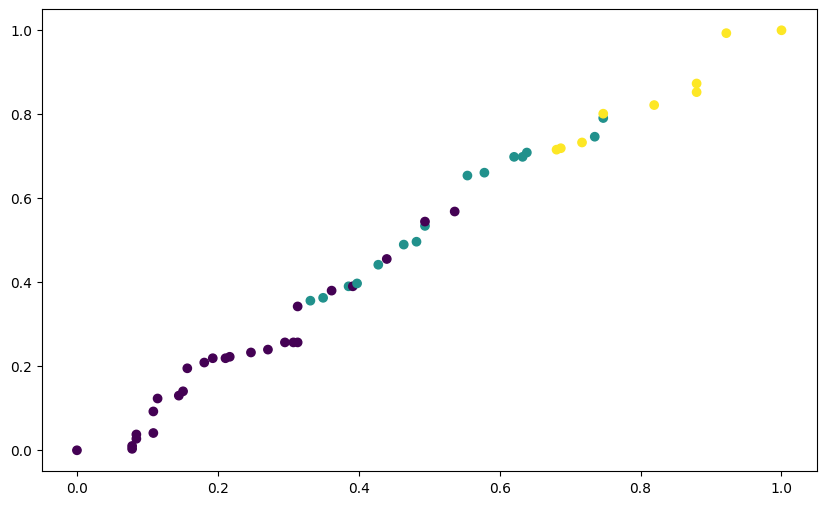

In [30]:
plt.scatter(X.Murder, X.Assault, c = clusters, cmap = "viridis");


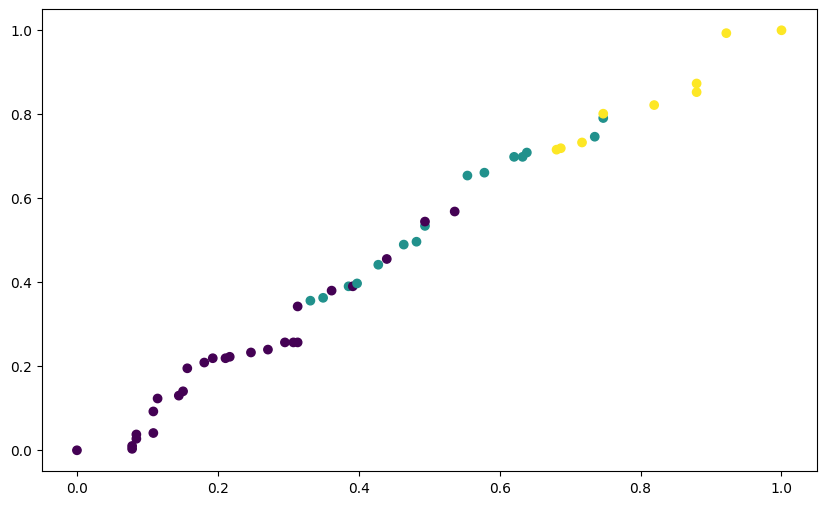

In [31]:
plt.scatter(X.Murder, X.Assault, c = clusters, cmap = "viridis");

In [32]:
clus_pred = X.groupby("cluster").mean().T
clus_pred

cluster,0,1,2
Murder,0.226135,0.522490,0.814592
Assault,0.215227,0.561872,0.834475
UrbanPop,0.543025,0.731073,0.370998
Rape,0.190320,0.428079,0.736721


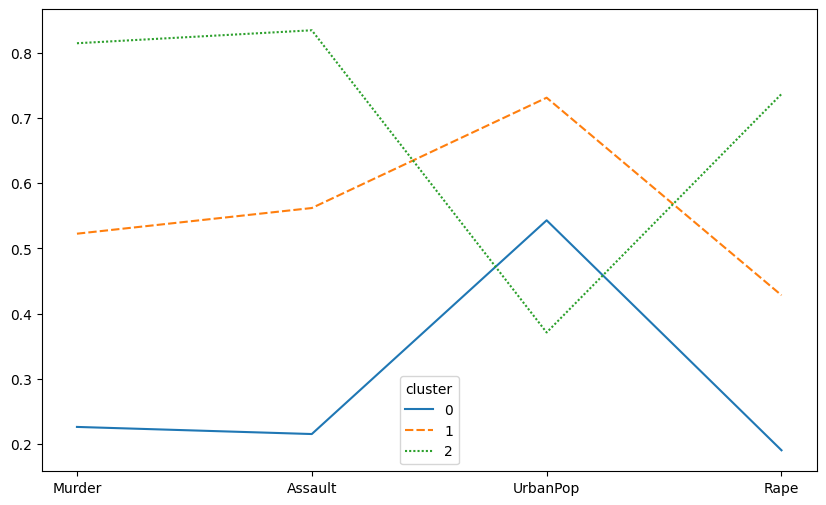

In [33]:
sns.lineplot(data = clus_pred);

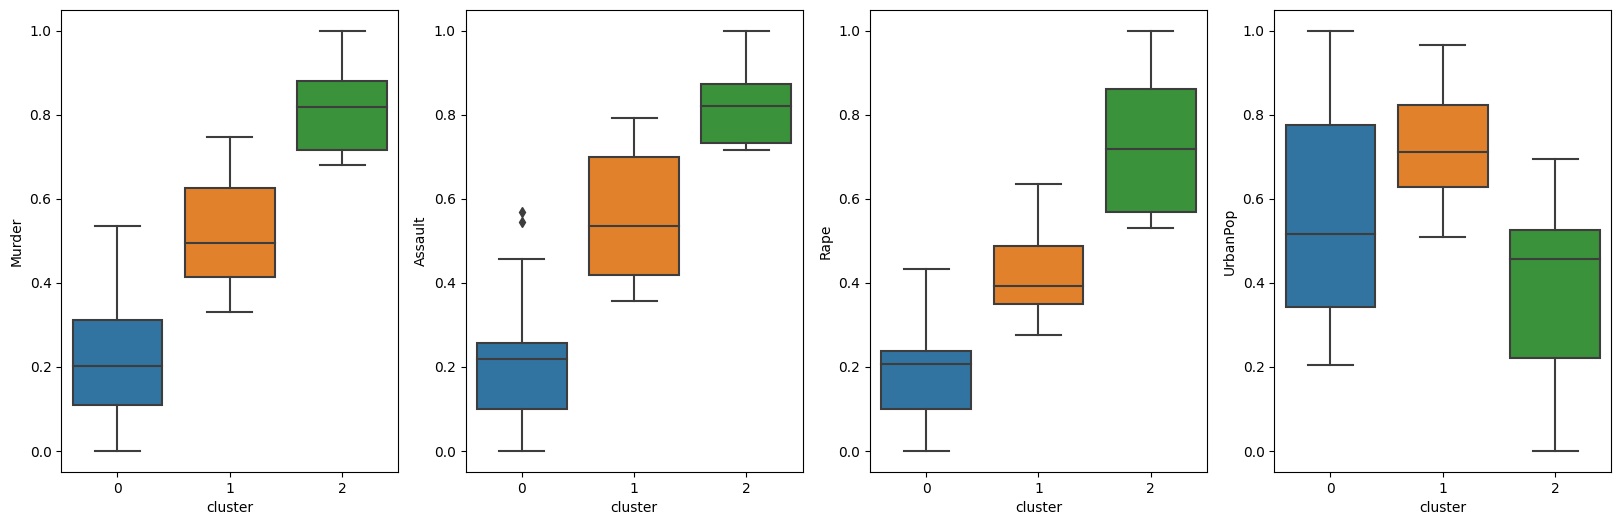

In [34]:
plt.figure(figsize = (20,6))

plt.subplot(141)
sns.boxplot(y = "Murder", x = "cluster", data = X)

plt.subplot(142)
sns.boxplot(y = "Assault", x = "cluster", data = X)

plt.subplot(143)
sns.boxplot(y = "Rape", x = "cluster", data = X)

plt.subplot(144)
sns.boxplot(y = "UrbanPop", x = "cluster", data = X);

In [35]:
X2 = X.iloc[:, [0,1,3]]
X2.head()

,Murder,Assault,Rape
0,0.000000,0.000000,0.000000
1,0.078313,0.003425,0.012920
2,0.078313,0.010274,0.025840
3,0.084337,0.027397,0.051680
4,0.084337,0.037671,0.056848


In [36]:
hc_ward = linkage(y = X2, method = "ward")
hc_complete = linkage(X2, "complete")
hc_average = linkage(X2, "average")
hc_single = linkage(X2, "single")

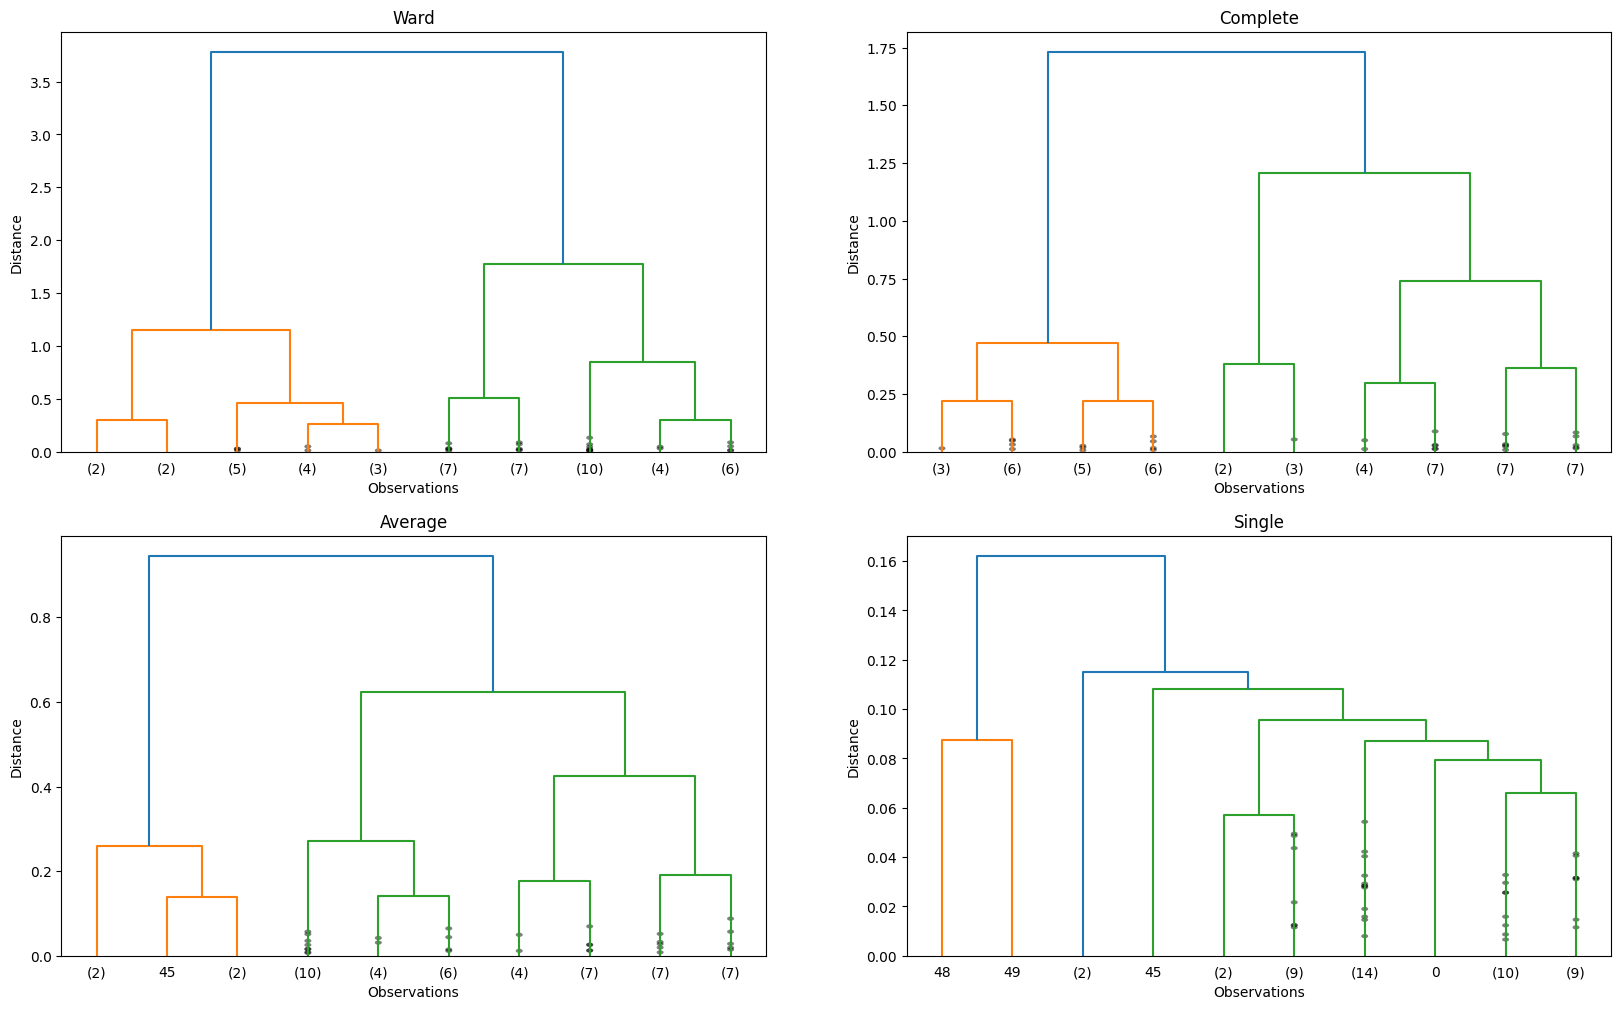

In [37]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10);

In [38]:
K = range(2,11)
for k in K:
    model = AgglomerativeClustering(n_clusters = k)
    model.fit_predict(X2)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(df, model.labels_)}')

Silhouette Score for 2 clusters: 0.5843563041221426
Silhouette Score for 3 clusters: 0.5408473507473215
Silhouette Score for 4 clusters: 0.49680242574181405
Silhouette Score for 5 clusters: 0.4610301160129345
Silhouette Score for 6 clusters: 0.45309851046082883
Silhouette Score for 7 clusters: 0.39604153006494913
Silhouette Score for 8 clusters: 0.39684807539987044
Silhouette Score for 9 clusters: 0.3700971634671143
Silhouette Score for 10 clusters: 0.36251487312336017


In [39]:
# Final Model

final_model = AgglomerativeClustering(n_clusters=3, affinity = "euclidean", linkage = "ward")
clusters = final_model.fit_predict(X2)
X2["cluster"] = clusters

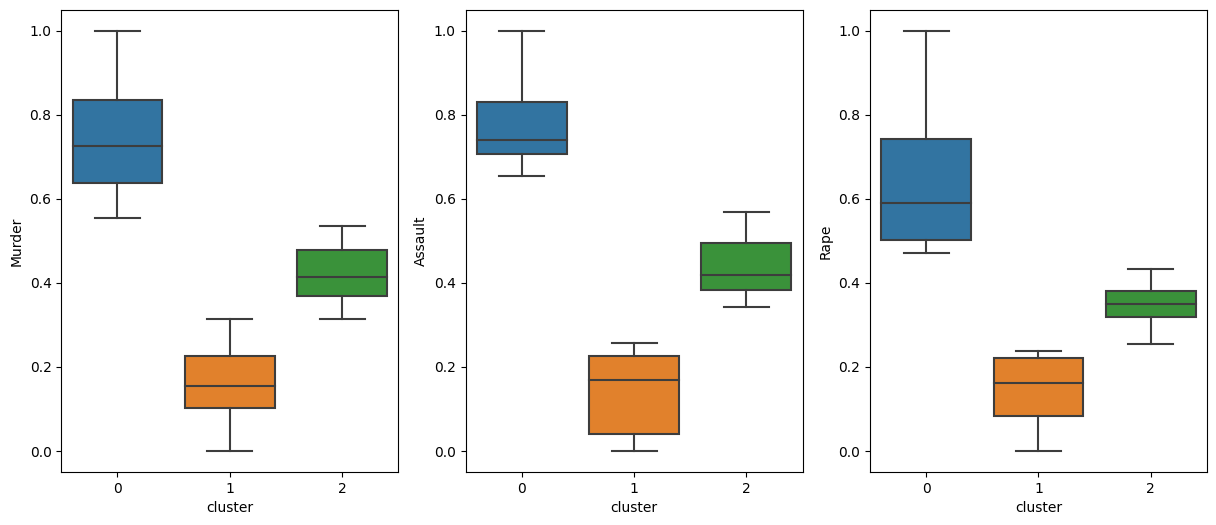

In [40]:
plt.figure(figsize = (20,6))

plt.subplot(141)
sns.boxplot(y = "Murder", x = "cluster", data = X2)

plt.subplot(142)
sns.boxplot(y = "Assault", x = "cluster", data = X2)

plt.subplot(143)
sns.boxplot(y = "Rape", x = "cluster", data = X2);

In [41]:
X2["crime_level"] = X2["cluster"].map({0:"high", 1:"low",2:"medium"})   # crime level diye bir feature olusturduk
X2.head()

,Murder,Assault,Rape,cluster,crime_level
0,0.000000,0.000000,0.000000,1,low
1,0.078313,0.003425,0.012920,1,low
2,0.078313,0.010274,0.025840,1,low
3,0.084337,0.027397,0.051680,1,low
4,0.084337,0.037671,0.056848,1,low


In [42]:
df.index

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='object')

In [43]:
X2["States"] = df.index   # index kısmına eyaletleri atadık
X2

,Murder,Assault,Rape,cluster,crime_level,States
0,0.000000,0.000000,0.000000,1,low,Alabama
1,0.078313,0.003425,0.012920,1,low,Alaska
2,0.078313,0.010274,0.025840,1,low,Arizona
3,0.084337,0.027397,0.051680,1,low,Arkansas
4,0.084337,0.037671,0.056848,1,low,California
5,0.108434,0.041096,0.090439,1,low,Colorado
6,0.108434,0.092466,0.098191,1,low,Connecticut
7,0.114458,0.123288,0.100775,1,low,Delaware
8,0.144578,0.130137,0.103359,1,low,Florida
9,0.150602,0.140411,0.142119,1,low,Georgia


In [44]:
X2[X2.crime_level=="low"]["States"]  # suç oranının düşük oldugu eyaletler

0         Alabama
1          Alaska
2         Arizona
3        Arkansas
4      California
5        Colorado
6     Connecticut
7        Delaware
8         Florida
9         Georgia
10         Hawaii
11          Idaho
12       Illinois
13        Indiana
14           Iowa
15         Kansas
16       Kentucky
17      Louisiana
18          Maine
19       Maryland
Name: States, dtype: object

In [45]:
X2[X2.crime_level=="high"]["States"]  # suç oranının yüksek oldugu eyaletler

34              Ohio
35          Oklahoma
36            Oregon
37      Pennsylvania
38      Rhode Island
39    South Carolina
40      South Dakota
41         Tennessee
42             Texas
43              Utah
44           Vermont
45          Virginia
46        Washington
47     West Virginia
48         Wisconsin
49           Wyoming
Name: States, dtype: object